In [1]:
import numpy as np
import fbprophet 
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from fbprophet.diagnostics import cross_validation, performance_metrics
# don't do this at home
warnings.filterwarnings("ignore")

# def validate():
"""
>> takes in 
    > Census 1970-2010 dataframe (1 df)
        >> total population by Place measurements
    > American Community Survey (ACS) 2011-2017 dataframes (7 dfs)
        >> total population (age & sex) by Place 

>> forges DataFrame of places that have 
    > at least one (1) recording for Census years 1970-2010
    > at least one (1) recording for ACS years 2011-2015

>> test our model v. base on
    > random sample 100 Places
    > random sample 100 Places from bottom half population size
    > random sample 100 Places from top half population size
"""

'''load Train data'''
# population by Place Census 1970-2010 measurements
load_census_place = pd.read_csv('../../data/NHGIS/nhgis0002_csv/nhgis0002_ts_nominal_place.csv',encoding='ISO-8859-1')
# population by Place ACS 2011
load_acs_20l1 = pd.read_csv('../../data/American_Community_Survey/ACS_11_5YR_S0101/ACS_11_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2012
load_acs_20l2 = pd.read_csv('../../data/American_Community_Survey/ACS_12_5YR_S0101/ACS_12_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2013
load_acs_20l3 = pd.read_csv('../../data/American_Community_Survey/ACS_13_5YR_S0101/ACS_13_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2014
load_acs_20l4 = pd.read_csv('../../data/American_Community_Survey/ACS_14_5YR_S0101/ACS_14_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2015
load_acs_20l5 = pd.read_csv('../../data/American_Community_Survey/ACS_15_5YR_S0101/ACS_15_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 


'''load Test data'''
# population by Place ACS 2016
load_acs_20l6 = pd.read_csv('../../data/American_Community_Survey/ACS_16_5YR_S0101/ACS_16_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 
# population by Place ACS 2017
load_acs_20l7 = pd.read_csv('../../data/American_Community_Survey/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv',encoding='ISO-8859-1',low_memory=False) 

'''find common places across Census and each train ACS'''
# identify Places measured in 2011 ACS [0 == 'Geography'] (# 29517)
acs11places = [place for place in load_acs_20l1['GEO.display-label'][1:]]
# identify Places measured in 2012 ACS  (# 29510)
acs12places = [place for place in load_acs_20l2['GEO.display-label']]
# identify Places measured in 2013 ACS (# 29510)
acs13places = [place for place in load_acs_20l3['GEO.display-label']]
# identify Places measured in 2014 ACS (# 29550)
acs14places = [place for place in load_acs_20l4['GEO.display-label']]
# identify Places measured in 2015 ACS (# 29575)
acs15places = [place for place in load_acs_20l5['GEO.display-label']]

# cross 2011-2015, keep coexisting Places (# 29475)
train_places = [place for place in acs11places if place in acs12places and acs13places and acs14places and acs15places]

"""find common places across 2016 & 2017 (test ACSs)
"""
# identify Places measured in 2016 ACS (# 29574) [0 == 'Geography']
acs16places = [place for place in load_acs_20l6['GEO.display-label'][1:]]
# identify Places measured in 2017 ACS (# 29577)
acs17places = [place for place in load_acs_20l7['GEO.display-label']]

# cross 2017 Places w/ 2016 Places, keep coexisting Places (# 29550)
base_places = [place for place in acs17places if place in acs16places]

"""find common Places across the Places our model will train on {train_places} 
    and the Places our model can predict on {base_places}
"""
# identify Places we can compare our predictions with (# 29341)
pre_measureable_places = [place for place in train_places if place in base_places]

"""clean Census 1970-2010 df (Train)
"""
# identify columns needed to make GEO.display-label column (so can pair with ACS DataFrames) 
for_geo_displays = ['PLACE','STATE']
# pull those columns 
to_geo_displays = load_census_place[for_geo_displays]

# mold PLACE column into list with Place formatted as is in GEO.display-label
places_70_10 = [place + ', ' for place in to_geo_displays.PLACE]

# list paired State for each Place
states_70_10 = [state for state in to_geo_displays.STATE]

# merge places_70_10 and states_70_10 into list formatted as GEO.display-label column
GEO_display_label = [ places_70_10[i] + states_70_10[i] for i in range(len(places_70_10))]

# identify columns relevant to our end goal of predicting population for a given place
place_cols_of_interest = ['AV0AA1970', 'AV0AA1980', 'AV0AA1990', 'AV0AA2000', 'AV0AA2010']
# set base dataframe using Census (1970-2010) measurements 
pop_place_70_10_ = load_census_place[place_cols_of_interest]

# add GEO.display-label column from GEO_display_label list (# 31436)
pop_place_70_10_['GEO.display-label'] = GEO_display_label

# forget places without measurements for at least 3 of the 5 census measurement years (# 23027)
at_least_3_70_10_ = pop_place_70_10_.dropna(axis=0,thresh=4)
# forget places with measurements of 0 for 2000 (# 23018)
not_0_for_2000_ = at_least_3_70_10_.loc[at_least_3_70_10_.AV0AA2000 != 0]
# forget places with measurements of 0 for 2010 (# 23016)
pop_place_70_10_ = not_0_for_2000_.loc[not_0_for_2000_.AV0AA2010 != 0]

# note the remaining places (total # = 23016)
census_places = [place for place in pop_place_70_10_['GEO.display-label']]
# adjust measurable places to reflect places with census measurements (total # = 22506)
measureable_places = [place for place in pre_measureable_places if place in census_places]

"""clean American Community Survey (ACS) 2011-2015 dataframes (Train)
"""
# ID columns we will be using
columns = ['GEO.display-label', 'HC01_EST_VC01']
# convert 2011
acs_20l1 = load_acs_20l1[columns]
# convert 2012
acs_20l2 = load_acs_20l2[columns]
# convert 2013
acs_20l3 = load_acs_20l3[columns]
# convert 2014
acs_20l4 = load_acs_20l4[columns]
# convert 2015
acs_20l5 = load_acs_20l5[columns]

"""convert Train years to reflect Places only seen in measureable_places
"""
# drop Census Places not ideal for measurement (29346)
census_place_populations = pop_place_70_10_.loc[pop_place_70_10_['GEO.display-label'].isin(measureable_places)]
# drop 2011 ACS Places not ideal for measurement (29341)
acs_2011_place_populations = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(measureable_places)]
# drop 2012 ACS Places not ideal for measurement (29341)
acs_2012_place_populations = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(measureable_places)]
# drop 2013 ACS Places not ideal for measurement (29341) 
acs_2013_place_populations = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(measureable_places)]
# drop 2014 ACS Places not ideal for measurement (29341) 
acs_2014_place_populations = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(measureable_places)]
# drop 2015 ACS Places not ideal for measurement (29341) 
acs_2015_place_populations = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(measureable_places)]

"""clean ACS 2016 & 2017 dataframes (Test)
    take a sample of n Places to score our model
"""
# identify 2016/2017 columns of interest (to measure against)
test_col_of_i = ['GEO.display-label', 'HC01_EST_VC01']

# shrink ACS 2017 df to columns to measure against only 
testd_16_ = load_acs_20l6[test_col_of_i]
# realize ACS 2016 combined measureable_places DataFrame (Baseline) dataframe 
test_16_df_ = testd_16_.loc[testd_16_['GEO.display-label'].isin(measureable_places)]

# shrink ACS 2017 df to columns to measure against only 
testd_17_ = load_acs_20l7[test_col_of_i]
# realize ACS 2017 combined measureable_places DataFrame (Baseline) dataframe 
test_17_df_ = testd_17_.loc[testd_17_['GEO.display-label'].isin(measureable_places)]
# conver
test_17_1000_pops = [float(population) for population in test_17_df_.HC01_EST_VC01]
# convert test_17_df_ populations to floats (numbers, from strings) 
test_17_df_.HC01_EST_VC01 = test_17_1000_pops
# forget Places with 2017 measured population less than 1,000 (13218 places remain)
test_17_df_ = test_17_df_.loc[test_17_df_.HC01_EST_VC01 >= 1000]

# locate and pull cities of interest
city_sfo = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'San Francisco city, California']
city_nyc = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New York city, New York']
city_nola = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'New Orleans city, Louisiana']
city_houston = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Houston city, Texas']
city_bville = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Bentonville city, Arkansas']
city_sidney = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Sidney city, Nebraska']
city_pleasanton = test_17_df_.loc[test_17_df_['GEO.display-label'] == 'Pleasanton city, California']
sample_one_hunnit = pd.concat([city_sfo,city_nyc,city_nola,city_houston,city_bville,city_sidney,city_pleasanton])
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]

# sample Baseline data for Places to evaluate model 
# sample_one_hunnit = test_17_df_.sample(2500)
# list Places for conversion of other Datas
sample_places = [place for place in sample_one_hunnit['GEO.display-label']]
print(sample_places)

"""adjust Train dataframes to sampled Places
"""
# shrink Census DataFrame to sampled Places
_s_census_ = census_place_populations.loc[census_place_populations['GEO.display-label'].isin(sample_places)]
# shrink 2011 ACS df to sampled Places 
_s_acs_2011_ = acs_20l1.loc[acs_20l1['GEO.display-label'].isin(sample_places)]
# shrink 2012 ACS DataFrame to sampled Places 
_s_acs_2012_ = acs_20l2.loc[acs_20l2['GEO.display-label'].isin(sample_places)]
# shrink 2013 ACS df to Places in sample  
_s_acs_2013_ = acs_20l3.loc[acs_20l3['GEO.display-label'].isin(sample_places)]
# shrink 2014 ACS DataFrame to sampled Places 
_s_acs_2014_ = acs_20l4.loc[acs_20l4['GEO.display-label'].isin(sample_places)]
# shrink 2015 ACS df to sampled Places 
_s_acs_2015_ = acs_20l5.loc[acs_20l5['GEO.display-label'].isin(sample_places)]

"""adjust Test dataframes to sampled Places
"""
# 2016 ACS df to sampled Places 
test_16_df = test_16_df_.loc[test_16_df_['GEO.display-label'].isin(sample_places)]
# reset 2016 ACS df index
test_16_df = test_16_df.set_index(test_16_df['GEO.display-label'])

# 2017 ACS DataFrame to sampled Places 
test_17_df = test_17_df_.loc[test_17_df_['GEO.display-label'].isin(sample_places)]
# reset 2017 ACS df index
test_17_df = test_17_df.set_index(test_17_df['GEO.display-label'])

"""forge combined Train/Test DataFrame 
    --ensure Place order remains unchanged
"""
# set Census index to Places, and forget Place column 
s_census_ = _s_census_.copy().set_index(_s_census_['GEO.display-label'])[['AV0AA1970','AV0AA1980','AV0AA1990','AV0AA2000','AV0AA2010']]
# rename Census columns to years for later datetime conversion
s_census_.columns = ['1970','1980','1990','2000','2010']

# set 2011 index to Places 
s_acs_2011_ = _s_acs_2011_.copy().set_index(_s_acs_2011_['GEO.display-label'])
# rename columns 
s_acs_2011_.columns = ['no','2011']
# only continue with year/measurement column
s_acs_2011_ = s_acs_2011_['2011']

# set 2012 index to Places 
s_acs_2012_ = _s_acs_2012_.copy().set_index(_s_acs_2012_['GEO.display-label'])
# rename columns 
s_acs_2012_.columns = ['no','2012']
# only continue with year/measurement column
s_acs_2012_ = s_acs_2012_['2012']

# set 2013 index to Places 
s_acs_2013_ = _s_acs_2013_.copy().set_index(_s_acs_2013_['GEO.display-label'])
# rename columns 
s_acs_2013_.columns = ['no','2013']
# only continue with year/measurement column
s_acs_2013_ = s_acs_2013_['2013']

# set 2014 index to Places 
s_acs_2014_ = _s_acs_2014_.copy().set_index(_s_acs_2014_['GEO.display-label'])
# rename columns 
s_acs_2014_.columns = ['no','2014']
# only continue with year/measurement column
s_acs_2014_ = s_acs_2014_['2014']

# set 2015 index to Places 
s_acs_2015_ = _s_acs_2015_.copy().set_index(_s_acs_2015_['GEO.display-label'])
# rename columns 
s_acs_2015_.columns = ['no','2015']
# only continue with year/measurement column
s_acs_2015_ = s_acs_2015_['2015']

# rename columns 
test_16_df.columns = ['no','2016']
# only continue with year/measurement column
test_16_df = test_16_df['2016']

# rename columns 
test_17_df.columns = ['no','2017']
# only continue with year/measurement column
test_17_df = test_17_df['2017']

# forge Train DataFrame and convert NaN values to 0 (assumes population not measured is 0) 
combined_df = pd.concat([s_census_,s_acs_2011_,s_acs_2012_,s_acs_2013_,s_acs_2014_,s_acs_2015_,test_16_df,test_17_df],axis=1).fillna(0)

# split train_df from combined_df
train_df = combined_df[['1970', '1980', '1990', '2000', '2010', '2011', '2012', '2013', '2014','2015']]
# split test_df form combined_df
test_df = combined_df[['2016', '2017']]

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


['San Francisco city, California', 'New York city, New York', 'New Orleans city, Louisiana', 'Houston city, Texas', 'Bentonville city, Arkansas', 'Sidney city, Nebraska', 'Pleasanton city, California']


INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse          rmse           mae      mape  coverage
0  148 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
1  153 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
2  158 days  1.944603e+07   4409.765821   4409.765821  0.123748       1.0
3  164 days  6.364561e+05    797.782010    797.782010  0.021486       1.0
4  169 days  3.973252e+06   1993.301728   1993.301728  0.051677       1.0
5  174 days  1.304893e+07   3612.330579   3612.330579  0.089485       0.0
6  179 days  2.599891e+06   1612.417754   1612.417754  0.037940       0.0
7  328 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
8  333 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
9  338 days  1.944603e+07   4409.765821   4409.765821  0.123748       1.0
10 344 days  6.364561e+05    797.782010    797.782010  0.021486       1.0
11 349 days  3.973252e+06   1993.301728   1993.301728  0.051677       1.0
12 354 days  1.304893e+07   3612.33057

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse         rmse          mae      mape  coverage
0  148 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
1  153 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
2  158 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
3  164 days  1.807894e+07  4251.933687  4251.933687  0.059478       0.0
4  169 days  2.407472e+07  4906.599328  4906.599328  0.067063       0.0
5  174 days  2.267739e+06  1505.901514  1505.901514  0.020076       0.0
6  179 days  4.315947e+06  2077.485704  2077.485704  0.026964       0.0
7  328 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
8  333 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
9  338 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
10 344 days  1.807894e+07  4251.933687  4251.933687  0.059478       0.0
11 349 days  2.407472e+07  4906.599328  4906.599328  0.067063       0.0
12 354 days  2.267739e+06  1505.901514  1505.901514  0.020076   

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse          rmse           mae      mape  coverage
0  148 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
1  153 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
2  158 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
3  164 days  4.939482e+08  22224.945469  22224.945469  0.027186       0.0
4  169 days  1.457417e+09  38176.133287  38176.133287  0.046047       0.0
5  174 days  1.186196e+07   3444.119497   3444.119497  0.004096       0.0
6  179 days  5.460951e+06   2336.867750   2336.867750  0.002748       0.0
7  328 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
8  333 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
9  338 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
10 344 days  4.939482e+08  22224.945469  22224.945469  0.027186       0.0
11 349 days  1.457417e+09  38176.133287  38176.133287  0.046047       0.0
12 354 days  1.186196e+07   3444.11949

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse          rmse           mae      mape  coverage
0  148 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
1  153 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
2  158 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
3  164 days  1.487675e+07   3857.038696   3857.038696  0.010804       0.0
4  169 days  5.817766e+09  76274.279796  76274.279796  0.207002       0.0
5  174 days  1.663195e+09  40782.289680  40782.289680  0.108251       0.0
6  179 days  1.238379e+09  35190.605353  35190.605353  0.091900       0.0
7  328 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
8  333 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
9  338 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
10 344 days  1.487675e+07   3857.038696   3857.038696  0.010804       0.0
11 349 days  5.817766e+09  76274.279796  76274.279796  0.207002       0.0
12 354 days  1.663195e+09  40782.28968

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse        rmse         mae      mape  coverage
0  148 days   1054.482687   32.472799   32.472799  0.004806       1.0
1  153 days     82.539216    9.085110    9.085110  0.001342       0.0
2  158 days    427.848866   20.684508   20.684508  0.003056       0.0
3  164 days  13573.760335  116.506482  116.506482  0.017209       0.0
4  169 days   2430.447188   49.299566   49.299566  0.007249       0.0
5  174 days    229.093344   15.135830   15.135830  0.002216       0.0
6  179 days    351.183331   18.739886   18.739886  0.002726       0.0
7  328 days   1054.482687   32.472799   32.472799  0.004806       1.0
8  333 days     82.539216    9.085110    9.085110  0.001342       0.0
9  338 days    427.848866   20.684508   20.684508  0.003056       0.0
10 344 days  13573.760335  116.506482  116.506482  0.017209       0.0
11 349 days   2430.447188   49.299566   49.299566  0.007249       0.0
12 354 days    229.093344   15.135830   15.135830  0.002216       0.0
13 359 days    351.1

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse           rmse            mae      mape  coverage
0  148 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
1  153 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
2  158 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
3  164 days  1.737693e+10  131821.579108  131821.579108  0.015942       0.0
4  169 days  2.081711e+11  456257.766803  456257.766803  0.054610       0.0
5  174 days  4.100839e+06    2025.052757    2025.052757  0.000240       0.0
6  179 days  7.145528e+08   26731.120162   26731.120162  0.003159       0.0
7  328 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
8  333 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
9  338 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
10 344 days  1.737693e+10  131821.579108  131821.579108  0.015942       0.0
11 349 days  2.081711e+11  456257.766803  456257.766803  0.054610       0.0
12 354 days 

INFO:fbprophet:n_changepoints greater than number of observations.Using 8.
INFO:fbprophet:Making 15 forecasts with cutoffs between 2009-02-07 00:00:00 and 2016-01-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 3.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 4.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.
INFO:fbprophet:n_changepoints greater than number of observations.Using 6.


    horizon           mse           rmse            mae      mape  coverage
0  148 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
1  153 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
2  158 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
3  164 days  4.848679e+09   69632.454958   69632.454958  0.032619       0.0
4  169 days  1.352955e+09   36782.533153   36782.533153  0.016966       1.0
5  174 days  1.456110e+09   38159.004671   38159.004671  0.017207       1.0
6  179 days  1.034152e+08   10169.324683   10169.324683  0.004539       1.0
7  328 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
8  333 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
9  338 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
10 344 days  4.848679e+09   69632.454958   69632.454958  0.032619       0.0
11 349 days  1.352955e+09   36782.533153   36782.533153  0.016966       1.0
12 354 days 

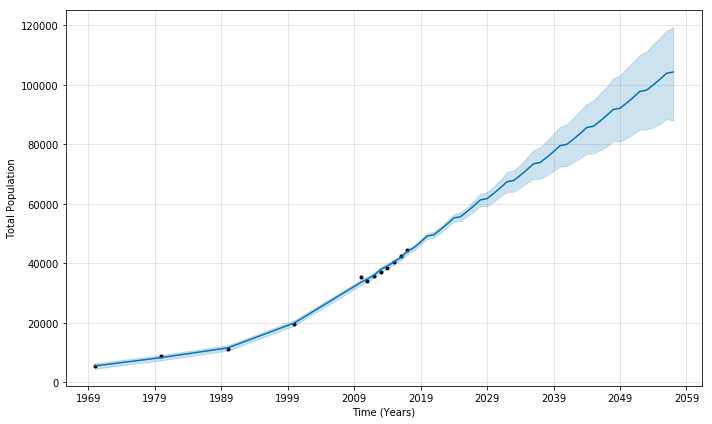

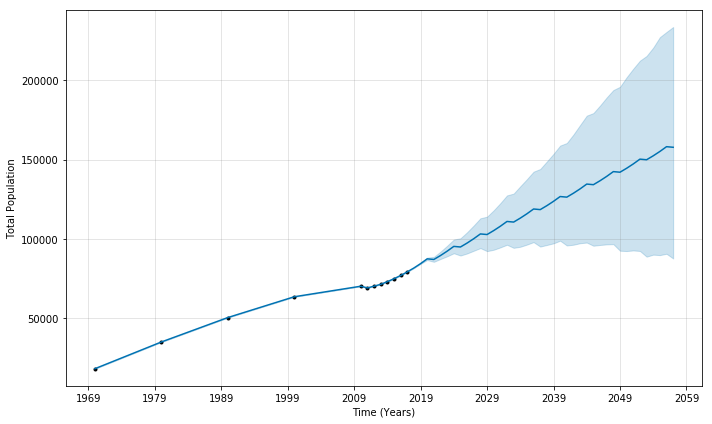

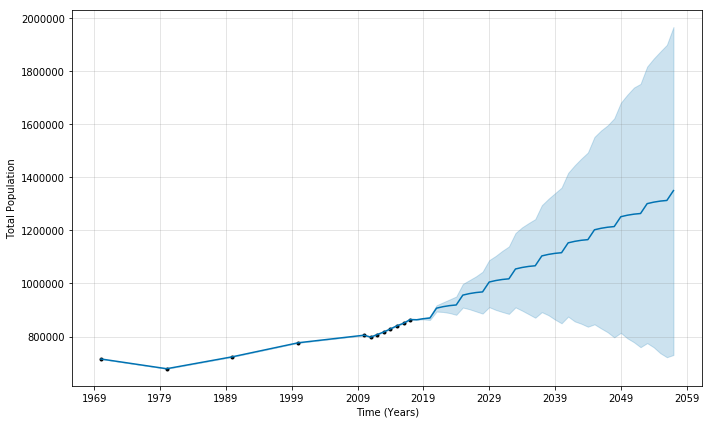

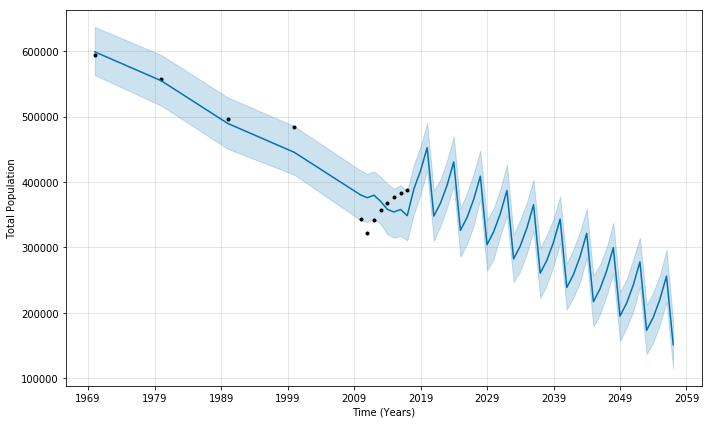

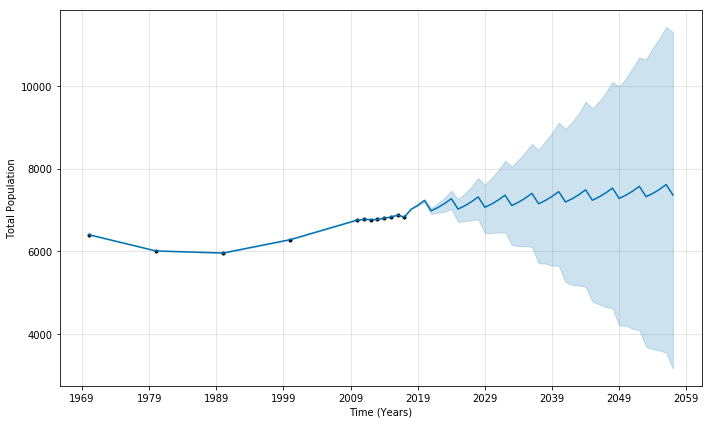

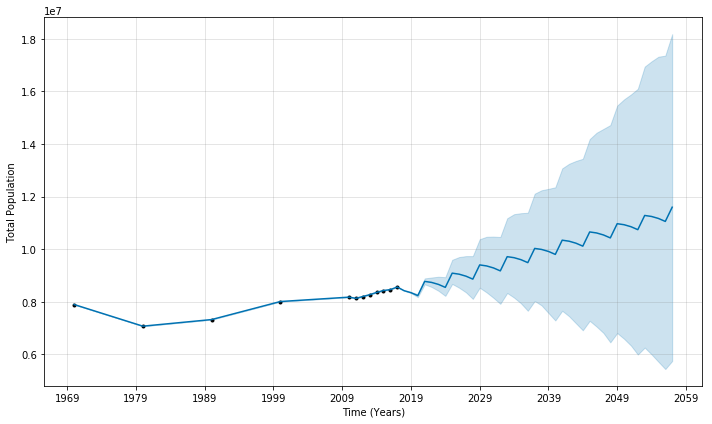

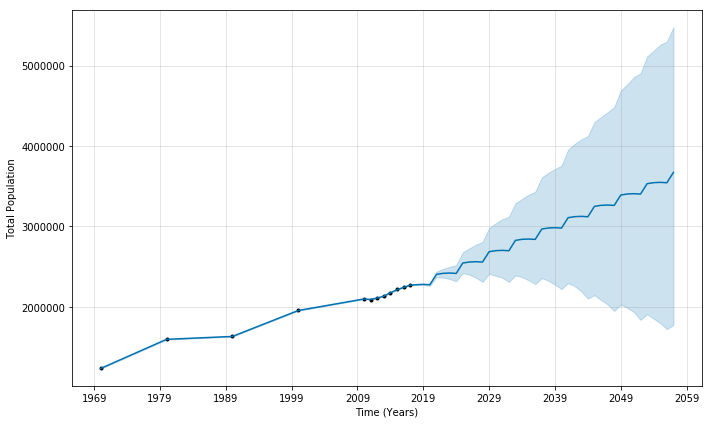

In [3]:
"""forecast 2016 and 2017 populations using model for each sample Place
"""
# set out route for forecast tables
out = []
# set out route for 2016 & 2017 Train predictions
train_preds = []
# set out for plots
plots = []
# record cross vals
xvals=[]

# make DataFrame of column values as datetime (first converting to Series)
datetimes = pd.DataFrame(data=pd.to_datetime(pd.Series(data=combined_df.columns)))

# go though each place in train_df
for i in range(len(combined_df)):
    # extract DataFrame for that place
    df = combined_df.iloc[i]
    # add datetime values to forge place specific DataFrame
    df = pd.concat([df.reset_index(),datetimes],axis=1)
    
    # use fbprophet to make Prophet model
    place_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15,
                                      daily_seasonality=False,
                                      weekly_seasonality=False,
                                      yearly_seasonality=True,
                                      n_changepoints=10)
    
    # rename Place df's columns to agree with prophet formatting
    df.columns = ['drop','y','ds']
    # adjust df ; forget index column (drop)
    df = df[['ds','y']]
    
    # fit place on prophet model 
    place_prophet.fit(df)
    df_cv = cross_validation(place_prophet, initial='14235 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv) 
    print(df_p)
    xvals.append(df_p)
    
    # make a future dataframe for 2016 & 2017 years
    place_forecast = place_prophet.make_future_dataframe(periods=40, 
                                                         freq='Y')
    
    # establish predictions
    forecast = place_prophet.predict(place_forecast)
    # model plot the forecase
    m_plot = place_prophet.plot(forecast, 
                                ax=None, 
                                uncertainty=True, 
                                plot_cap=True, 
                                xlabel='Time (Years)', 
                                ylabel='Total Population')
    # add to plots
    plots.append(m_plot)
    
    
    # tag and bag (forecast table)
    out.append(forecast)
    # store 2016 and 2017 predictions
#     train_preds.append([
#         forecast.loc[forecast.ds == '2016-12-31'].yhat.values[0],
#         forecast.loc[forecast.ds == '2017-12-31'].yhat.values[0]])

    horizon           mse          rmse           mae      mape  coverage
0  148 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
1  153 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
2  158 days  1.944603e+07   4409.765821   4409.765821  0.123748       1.0
3  164 days  6.364561e+05    797.782010    797.782010  0.021486       1.0
4  169 days  3.973252e+06   1993.301728   1993.301728  0.051677       1.0
5  174 days  1.304893e+07   3612.330579   3612.330579  0.089485       0.0
6  179 days  2.599891e+06   1612.417754   1612.417754  0.037940       0.0
7  328 days  2.067300e+08  14378.107679  14378.107679  0.407300       0.0
8  333 days  1.164756e+07   3412.851857   3412.851857  0.100313       1.0
9  338 days  1.944603e+07   4409.765821   4409.765821  0.123748       1.0
10 344 days  6.364561e+05    797.782010    797.782010  0.021486       1.0
11 349 days  3.973252e+06   1993.301728   1993.301728  0.051677       1.0
12 354 days  1.304893e+07   3612.33057

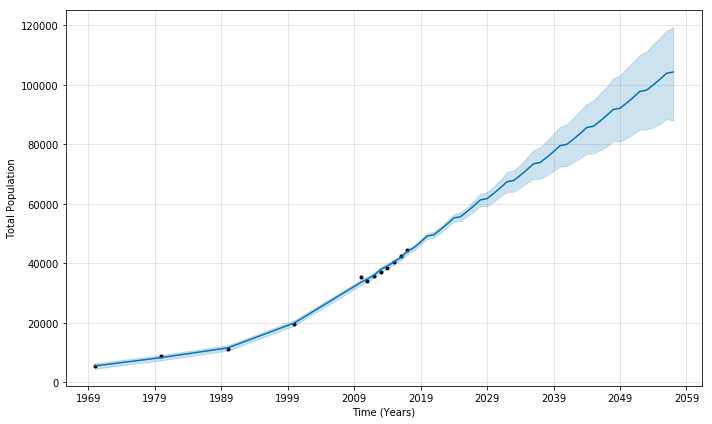

In [15]:
# bentonville
print(xvals[0])
plots[0]

    horizon           mse         rmse          mae      mape  coverage
0  148 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
1  153 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
2  158 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
3  164 days  1.807894e+07  4251.933687  4251.933687  0.059478       0.0
4  169 days  2.407472e+07  4906.599328  4906.599328  0.067063       0.0
5  174 days  2.267739e+06  1505.901514  1505.901514  0.020076       0.0
6  179 days  4.315947e+06  2077.485704  2077.485704  0.026964       0.0
7  328 days  7.489831e+07  8654.380999  8654.380999  0.123133       0.0
8  333 days  5.310029e+06  2304.350082  2304.350082  0.033290       0.0
9  338 days  2.130062e+02    14.594730    14.594730  0.000208       0.0
10 344 days  1.807894e+07  4251.933687  4251.933687  0.059478       0.0
11 349 days  2.407472e+07  4906.599328  4906.599328  0.067063       0.0
12 354 days  2.267739e+06  1505.901514  1505.901514  0.020076   

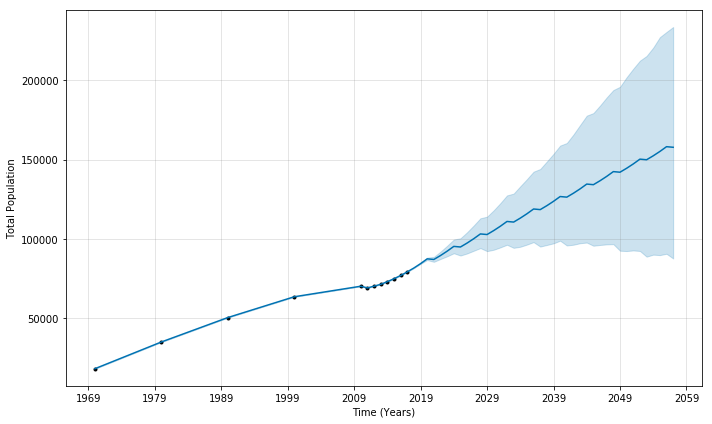

In [16]:
# pleasanton
print(xvals[1])
plots[1]

    horizon           mse          rmse           mae      mape  coverage
0  148 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
1  153 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
2  158 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
3  164 days  4.939482e+08  22224.945469  22224.945469  0.027186       0.0
4  169 days  1.457417e+09  38176.133287  38176.133287  0.046047       0.0
5  174 days  1.186196e+07   3444.119497   3444.119497  0.004096       0.0
6  179 days  5.460951e+06   2336.867750   2336.867750  0.002748       0.0
7  328 days  9.249058e+08  30412.263505  30412.263505  0.037768       0.0
8  333 days  2.344978e+08  15313.322297  15313.322297  0.019190       0.0
9  338 days  2.309934e+06   1519.846706   1519.846706  0.001882       0.0
10 344 days  4.939482e+08  22224.945469  22224.945469  0.027186       0.0
11 349 days  1.457417e+09  38176.133287  38176.133287  0.046047       0.0
12 354 days  1.186196e+07   3444.11949

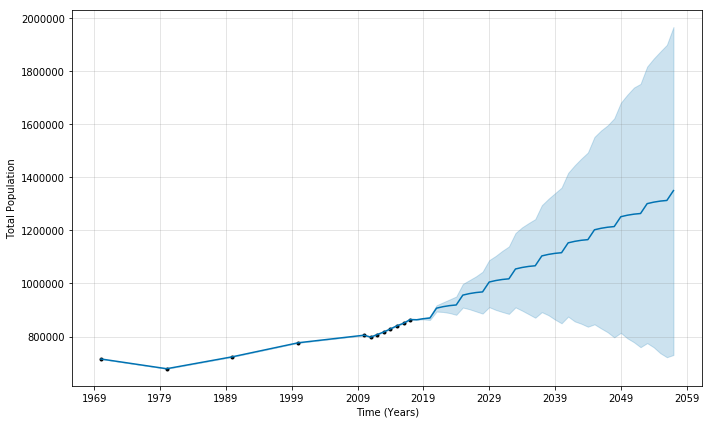

In [17]:
# sfo
print(xvals[2])
plots[2]

    horizon           mse          rmse           mae      mape  coverage
0  148 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
1  153 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
2  158 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
3  164 days  1.487675e+07   3857.038696   3857.038696  0.010804       0.0
4  169 days  5.817766e+09  76274.279796  76274.279796  0.207002       0.0
5  174 days  1.663195e+09  40782.289680  40782.289680  0.108251       0.0
6  179 days  1.238379e+09  35190.605353  35190.605353  0.091900       0.0
7  328 days  6.484398e+09  80525.757596  80525.757596  0.234203       0.0
8  333 days  4.630875e+08  21519.467827  21519.467827  0.066954       0.0
9  338 days  1.864555e+08  13654.869666  13654.869666  0.039996       0.0
10 344 days  1.487675e+07   3857.038696   3857.038696  0.010804       0.0
11 349 days  5.817766e+09  76274.279796  76274.279796  0.207002       0.0
12 354 days  1.663195e+09  40782.28968

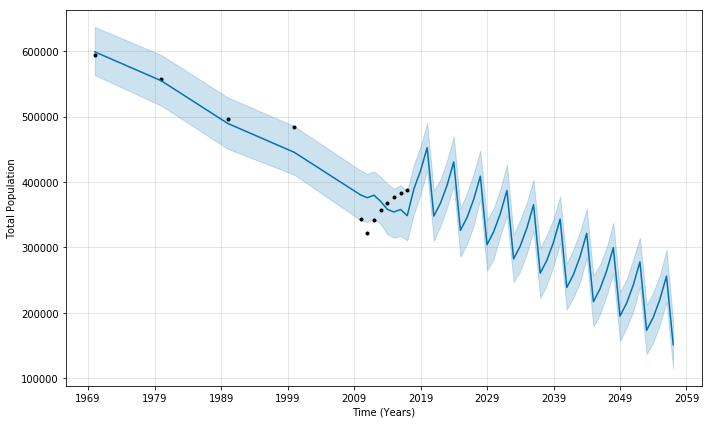

In [18]:
# nola
print(xvals[3])
plots[3]

    horizon           mse        rmse         mae      mape  coverage
0  148 days   1054.482687   32.472799   32.472799  0.004806       1.0
1  153 days     82.539216    9.085110    9.085110  0.001342       0.0
2  158 days    427.848866   20.684508   20.684508  0.003056       0.0
3  164 days  13573.760335  116.506482  116.506482  0.017209       0.0
4  169 days   2430.447188   49.299566   49.299566  0.007249       0.0
5  174 days    229.093344   15.135830   15.135830  0.002216       0.0
6  179 days    351.183331   18.739886   18.739886  0.002726       0.0
7  328 days   1054.482687   32.472799   32.472799  0.004806       1.0
8  333 days     82.539216    9.085110    9.085110  0.001342       0.0
9  338 days    427.848866   20.684508   20.684508  0.003056       0.0
10 344 days  13573.760335  116.506482  116.506482  0.017209       0.0
11 349 days   2430.447188   49.299566   49.299566  0.007249       0.0
12 354 days    229.093344   15.135830   15.135830  0.002216       0.0
13 359 days    351.1

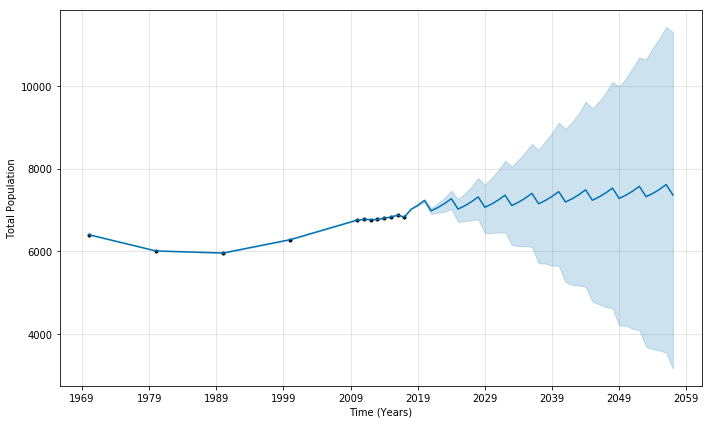

In [19]:
# sidney
print(xvals[4])
plots[4]

    horizon           mse           rmse            mae      mape  coverage
0  148 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
1  153 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
2  158 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
3  164 days  1.737693e+10  131821.579108  131821.579108  0.015942       0.0
4  169 days  2.081711e+11  456257.766803  456257.766803  0.054610       0.0
5  174 days  4.100839e+06    2025.052757    2025.052757  0.000240       0.0
6  179 days  7.145528e+08   26731.120162   26731.120162  0.003159       0.0
7  328 days  4.672840e+10  216167.524607  216167.524607  0.026442       1.0
8  333 days  3.681501e+10  191872.379907  191872.379907  0.023604       0.0
9  338 days  1.422446e+08   11926.635074   11926.635074  0.001455       0.0
10 344 days  1.737693e+10  131821.579108  131821.579108  0.015942       0.0
11 349 days  2.081711e+11  456257.766803  456257.766803  0.054610       0.0
12 354 days 

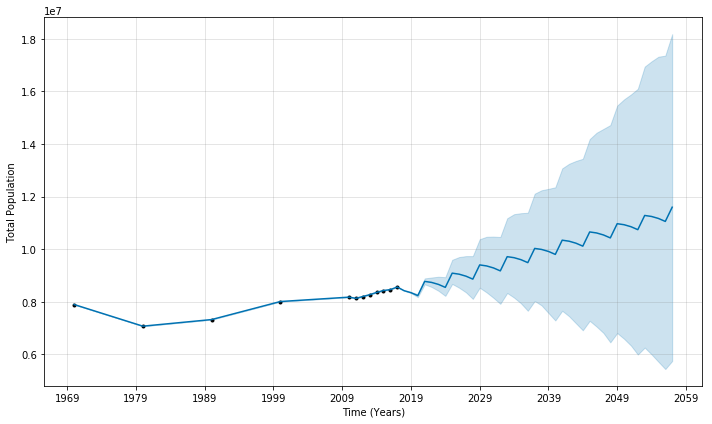

In [20]:
# nyc
print(xvals[5])
plots[5]

    horizon           mse           rmse            mae      mape  coverage
0  148 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
1  153 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
2  158 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
3  164 days  4.848679e+09   69632.454958   69632.454958  0.032619       0.0
4  169 days  1.352955e+09   36782.533153   36782.533153  0.016966       1.0
5  174 days  1.456110e+09   38159.004671   38159.004671  0.017207       1.0
6  179 days  1.034152e+08   10169.324683   10169.324683  0.004539       1.0
7  328 days  1.267404e+10  112579.026117  112579.026117  0.053623       0.0
8  333 days  1.134781e+10  106526.122348  106526.122348  0.050992       0.0
9  338 days  7.260716e+09   85209.837180   85209.837180  0.040433       0.0
10 344 days  4.848679e+09   69632.454958   69632.454958  0.032619       0.0
11 349 days  1.352955e+09   36782.533153   36782.533153  0.016966       1.0
12 354 days 

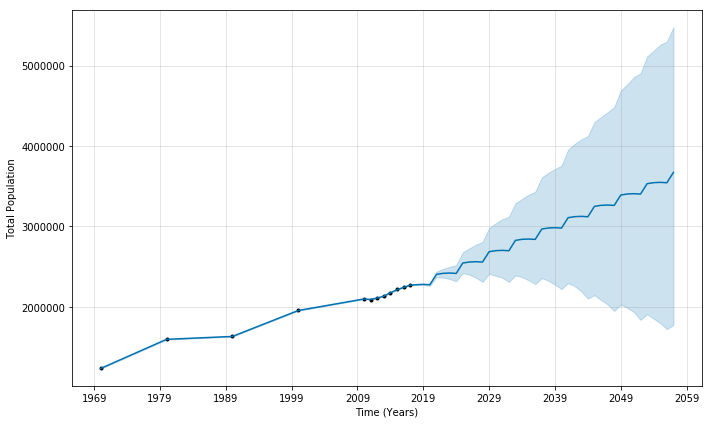

In [21]:
# houston
print(xvals[6])
plots[6]

In [12]:
combined_df

,1970,1980,1990,2000,2010,2011,2012,2013,2014,2015,2016,2017
GEO.display-label,,,,,,,,,,,,
"Bentonville city, Arkansas",5508.0,8756.0,11257.0,19730.0,35301.0,34022,35635,37131,38572,40368,42499,44601.0
"Pleasanton city, California",18328.0,35160.0,50553.0,63654.0,70285.0,69220,70329,71488,73164,75009,77046,79341.0
"San Francisco city, California",715674.0,678974.0,723959.0,776733.0,805235.0,797983,807755,817501,829072,840763,850282,864263.0
"New Orleans city, Louisiana",593471.0,557515.0,496938.0,484674.0,343829.0,321409,341407,357013,368471,376738,382922,388182.0
"Sidney city, Nebraska",6403.0,6010.0,5959.0,6282.0,6757.0,6772,6768,6770,6801,6830,6875,6830.0
"New York city, New York",7894862.0,7071639.0,7322564.0,8008278.0,8175133.0,8128980,8199221,8268999,8354889,8426743,8461961,8560072.0
"Houston city, Texas",1232802.0,1595138.0,1630553.0,1953631.0,2099451.0,2089090,2107449,2134707,2167988,2217706,2240582,2267336.0
